__Identitas__

Nama : Royzan Wida Saputra 

NIM : A11.2023.15506

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier



Step 1: Pengumpulan Data

In [40]:
# Step 1: Pengumpulan Data
file_path = 'water_potability.csv'
water_data = pd.read_csv(file_path)
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Step 2: Menelaah Data

In [41]:
# Step 2: Menelaah Data
print("\nInformasi Dataset:")
print(water_data.info())
print("\nNilai Unik Tiap Kolom:")
print(water_data.nunique())




Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None

Nilai Unik Tiap Kolom:
ph                 2785
Hardness           3276
Solids             3276
Chloramines        3276
Sulfate            2495
Conductivity       3276
Organic_carbon     3276
Trihalomethanes    3114
Turbidity          3276
Potability            2


Step 3: Validasi dan Visualisasi Data



Missing Values:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


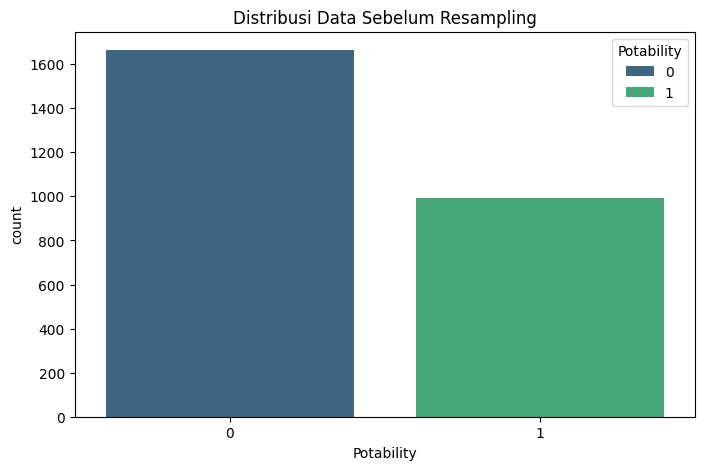

In [42]:
# Step 3: Validasi dan Visualisasi Data
# Cek missing values
print("\nMissing Values:")
print(water_data.isnull().sum())

# Imputasi missing values dengan rata-rata
water_data.fillna(water_data.mean(), inplace=True)

# Cek dan tangani outlier (menggunakan IQR)
for column in water_data.columns[:-1]:  # Semua kolom kecuali target
    Q1 = water_data[column].quantile(0.25)
    Q3 = water_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    water_data = water_data[(water_data[column] >= lower_bound) & (water_data[column] <= upper_bound)]

# Visualisasi distribusi sebelum resampling
plt.figure(figsize=(8, 5))
sns.countplot(x='Potability', hue='Potability', data=water_data, palette='viridis')
plt.title('Distribusi Data Sebelum Resampling')
plt.show()



Step 4: Menentukan Objek Data

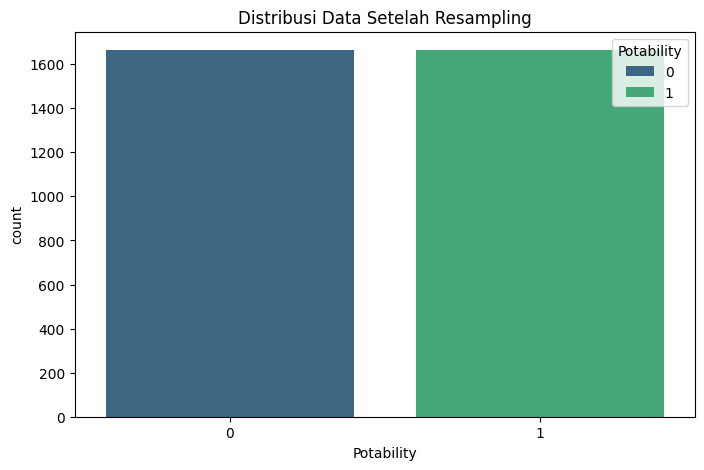

In [43]:
# Step 4: Menentukan Objek Data
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
target = 'Potability'
X = water_data[features]
y = water_data[target]

# Resampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Visualisasi distribusi setelah resampling
plt.figure(figsize=(8, 5))
sns.countplot(x=y_resampled, hue=y_resampled, palette='viridis')
plt.title('Distribusi Data Setelah Resampling')
plt.show()



Step 5: Membersihkan Data

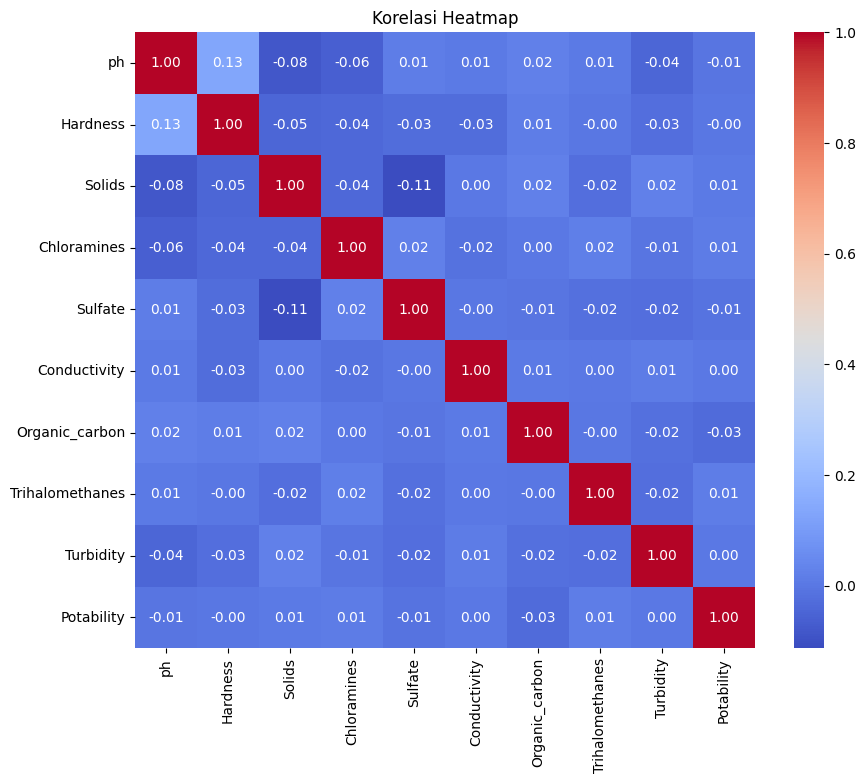

In [44]:
# Step 5: Membersihkan Data
# Korelasi Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = water_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Heatmap')
plt.show()

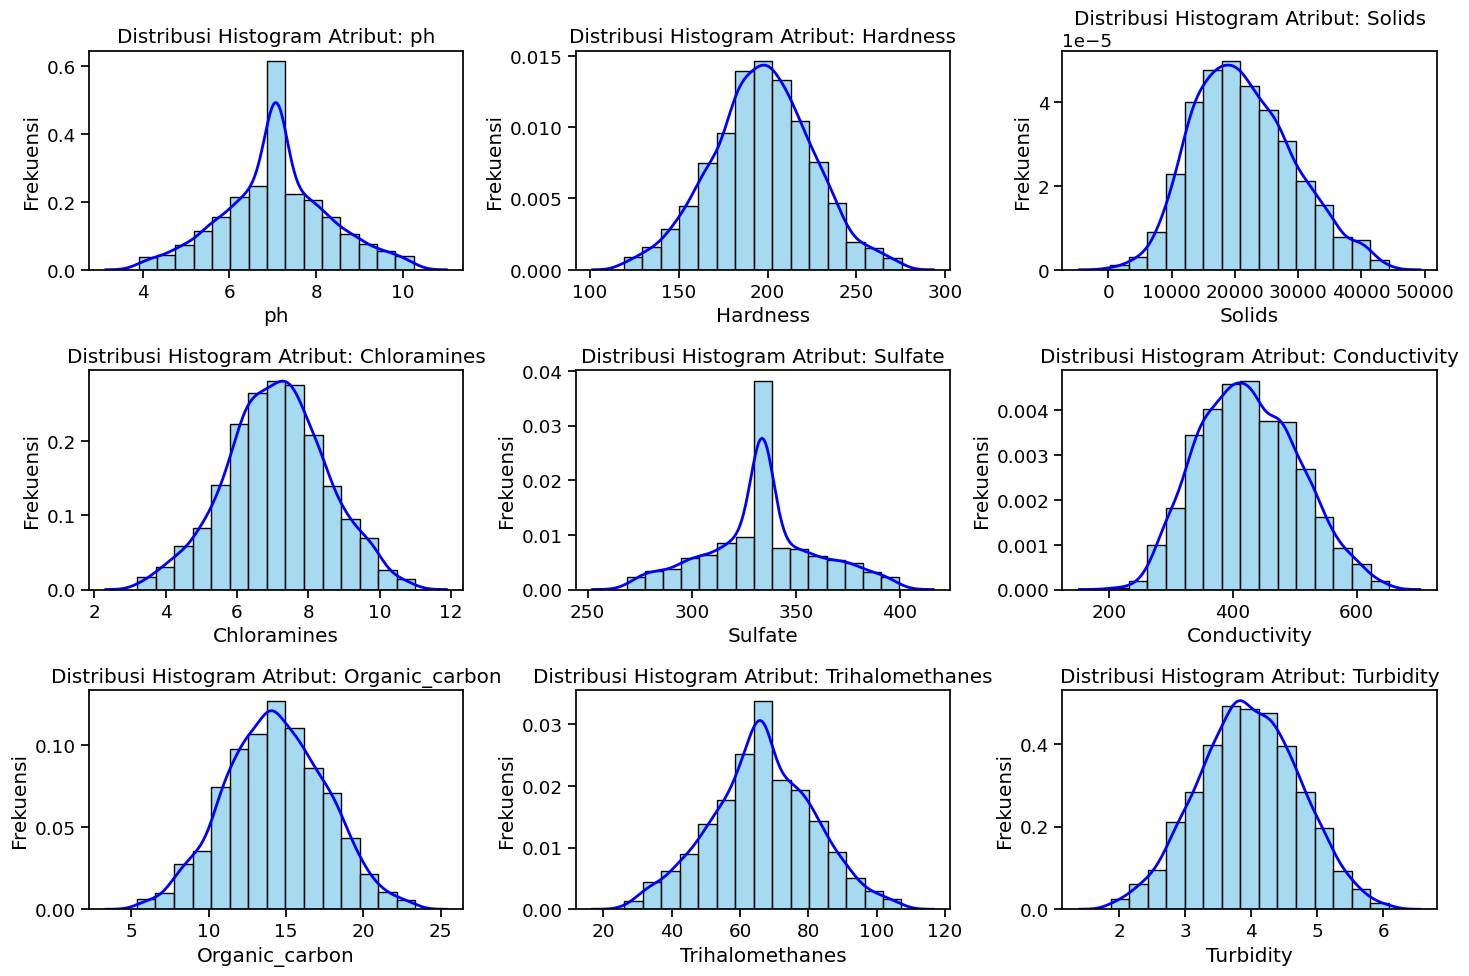

In [45]:
# Distribusi Histogram Plot dengan Bar dan Line
with sns.plotting_context("notebook", font_scale=1.2):
    fig, axes = plt.subplots(nrows=len(features)//3 + (len(features) % 3 > 0), ncols=3, figsize=(15, 10))
    for i, feature in enumerate(features):
        ax = axes[i // 3, i % 3]  # Mengatur subplot berdasarkan indeks
        sns.histplot(data=water_data[feature], stat='density', color='skyblue', bins=15, edgecolor='black', ax=ax)
        sns.kdeplot(data=water_data[feature], color='blue', linewidth=2, ax=ax)
        ax.set_title(f'Distribusi Histogram Atribut: {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Frekuensi')
    
    plt.tight_layout()  # Mengatur layout agar tidak tumpang tindih
    plt.show()

Step 6: Konstruksi Data (Penskalaan Data)

In [46]:
# Step 6: Konstruksi Data (Penskalaan Data)
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

Step 7: Pemodelan

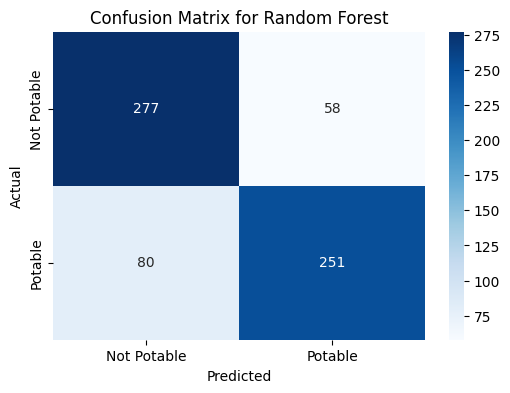

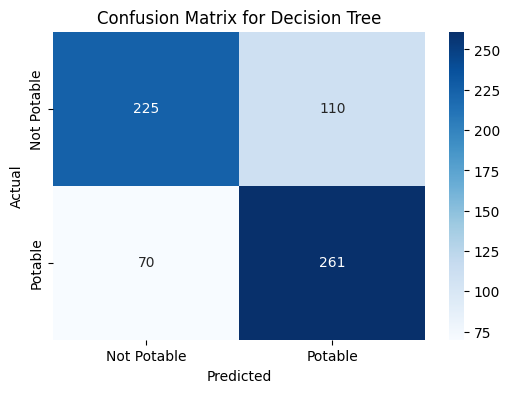

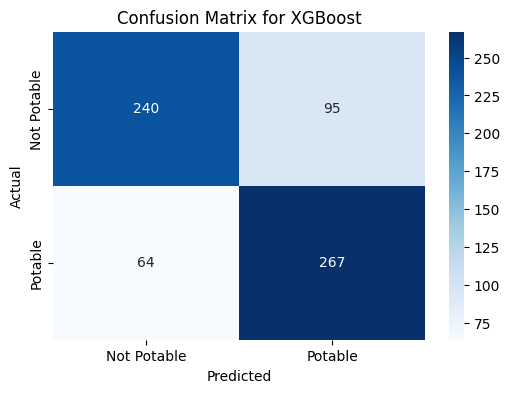

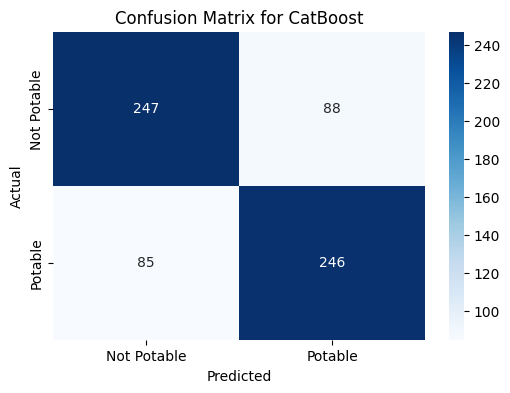

In [47]:
# Step 7: Pemodelan
# Split data (dengan data sudah dinormalisasi sebelumnya)
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

# Model definisi
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

# Train dan evaluasi model
results_normalized = {}
conf_matrices = {}

for name, model in models.items():
    # Fit dan prediksi
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Simpan akurasi dan confusion matrix
    results_normalized[name] = accuracy_score(y_test, y_pred)
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Tampilkan gambar confusion matrix
num_models = len(conf_matrices)

for i, (model, matrix) in enumerate(conf_matrices.items()):
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Potable', 'Potable'], yticklabels=['Not Potable', 'Potable'])
    plt.title(f'Confusion Matrix for {model}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()  # Menampilkan plot menggunakan matplotlib


Step 8: Evaluasi

In [48]:
# Step 8: Evaluasi
# Sebelum Normalisasi
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

results_raw = {}
for name, model in models.items():
    model.fit(X_train_raw, y_train_raw)
    y_pred_raw = model.predict(X_test_raw)
    results_raw[name] = accuracy_score(y_test_raw, y_pred_raw)

# Tampilkan hasil
print("\nAkurasi Sebelum Normalisasi:")
for model, acc in results_raw.items():
    print(f"{model}: {acc*100:.2f}%")

print("\nAkurasi Setelah Normalisasi:")
for model, acc in results_normalized.items():
    print(f"{model}: {acc*100:.2f}%")



Akurasi Sebelum Normalisasi:
Random Forest: 79.28%
Decision Tree: 72.97%
XGBoost: 76.13%
CatBoost: 73.57%

Akurasi Setelah Normalisasi:
Random Forest: 79.28%
Decision Tree: 72.97%
XGBoost: 76.13%
CatBoost: 74.02%


# Kesimpulan dari Hasil Analisis

Berdasarkan hasil analisis perbandingan algoritma yang digunakan, berikut adalah kesimpulan:

1. Tingkat Akurasi Setiap Algoritma
    
    Akurasi Sebelum Normalisasi:

    - Random Forest: 79.28%

    - Decision Tree: 72.97%

    - XGBoost: 76.13%

    - CatBoost: 73.57%

    Akurasi Setelah Normalisasi:

    - Random Forest: 79.28%

    - Decision Tree: 72.97%

    - XGBoost: 76.13%

    - CatBoost: 74.02%

2. Keunggulan dan keterbatasan

    Random Forest: 
    - Keunggulan: Tahan terhadap overfitting, dapat menangani data yang hilang.
    - Keterbatasan: Memerlukan lebih banyak waktu untuk pelatihan dibandingkan algoritma lain.
    
    Decision Tree: 
    - Keunggulan: Mudah dipahami dan diinterpretasikan.
    - Keterbatasan: Rentan terhadap overfitting jika tidak dipangkas dengan baik.
    
    XGBoost: 
    - Keunggulan: Sangat cepat dan efisien, sering memberikan hasil yang sangat baik.
    - Keterbatasan: Memerlukan tuning parameter yang lebih banyak.
    
    CatBoost: 
    - Keunggulan: Baik untuk data kategorikal, tidak memerlukan preprocessing yang banyak.
    - Keterbatasan: Memerlukan lebih banyak sumber daya komputasi.
 
 3. Rekomendasi algoritma yang paling efektif
    Berdasarkan analisis di atas, Random Forest direkomendasikan sebagai algoritma yang paling efektif untuk kasus ini. 
    Alasan mengapa Random Forest optimal adalah:
    - Tingkat akurasi yang tinggi setelah normalisasi.
    - Tahan terhadap overfitting dan dapat menangani data yang hilang dengan baik.
    - Kemampuan untuk memberikan hasil yang stabil dan akurat pada berbagai jenis data.